In [1]:
import torch
import torch.nn as nn

import time
import numpy as np
import skimage.color as color
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import transforms as tf, datasets as ds
from torchvision.utils import make_grid

In [2]:
data_root_color = 'C:/DataSets/Celeba/sample'
data_root_grayscale = 'C:/DataSets/Celeba/grayscale'
workers = 0
batch_size = 10
image_size = 256
nc = 3  # Number of output color channels.
nz = 1  # Number of input color channels (Latent vector).
ngf = 64    # Depth of feature map, carried through the generator(G).
ndf = 64    # Depth of feature map, carried through the discriminator(D).
number_epochs = 5
lr = 2e-4
beta = 5e-1
ngpu = 1
weight_decay = 1e-1

In [3]:
is_cuda_available = torch.cuda.is_available()
device = torch.device('cuda:0' if is_cuda_available and ngpu > 0 else 'cpu')
device

device(type='cuda', index=0)

In [8]:
image_transform = {
    "rgb": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    "gray": tf.Compose([
        tf.Resize(image_size),
        tf.CenterCrop(image_size),
        tf.ToTensor()
        # tf.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [9]:
# Grayscale image dataset load.
gray_set = ds.ImageFolder(root=data_root_grayscale, transform=image_transform["gray"])

In [10]:
gray_loader = DataLoader(gray_set, batch_size, shuffle=True, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'GRAYSCALE IMAGE SAMPLE')

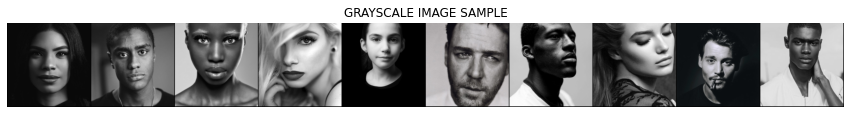

In [11]:
g_im = next(iter(gray_loader))

g_grid = make_grid(g_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(g_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('GRAYSCALE IMAGE SAMPLE')

In [12]:
color_set = ds.ImageFolder(root=data_root_color, transform=image_transform["rgb"])

In [13]:
color_loader = DataLoader(color_set, batch_size, shuffle=False, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'COLOR IMAGE SAMPLE')

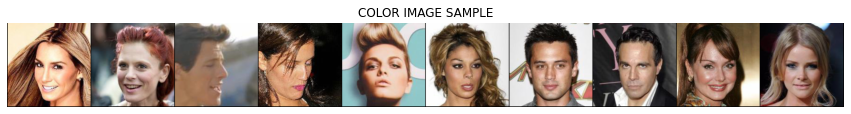

In [14]:
c_im = next(iter(color_loader))

c_grid = make_grid(c_im[0], nrow=10, normalize=True)

plt.figure(figsize=(15, 14))
plt.imshow(np.transpose(c_grid, axes=(1, 2, 0)))
plt.axis('off')
plt.title('COLOR IMAGE SAMPLE')

In [15]:
class RGB2LAB(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))

class RGB2L(object):

    def __call__(self, image):
        """
        :param image: PIL/NumPy image to be converted.
        :return: the LAB color channel image.
        """
        return color.rgb2lab(np.array(image))[:, :, 0]


In [16]:
def lab2rgb(image, dim=None):
    """
    :param image is a single Lab image the shape of (X, y, 3)
    :param dim to define the color-channel dimension.
    """
    image = np.transpose(image, axes=(1, 2, 0))

    if dim is not None:
        z = np.zeros_like(image)
        if dim != 0:
            z[:, :, 0] = 80  # Increase the brightness to see other color channels(a & b).

        z[:, :, dim] = image[:, :, dim]
        return color.lab2rgb(z)
    else:
        return color.lab2rgb(image)

In [17]:
image_transform['lab'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2LAB(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

image_transform['l'] = tf.Compose([
    tf.Resize(image_size),
    tf.CenterCrop(image_size),
    RGB2L(),
    tf.ToTensor()
    # tf.Normalize(mean=[0.5], std=[0.5])
])

In [18]:
lab_set = ds.ImageFolder(root=data_root_color, transform=image_transform['lab'])
lab_loader = DataLoader(lab_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

In [19]:
l_set = ds.ImageFolder(root=data_root_color, transform=image_transform['l'])
l_loader = DataLoader(l_set, batch_size, num_workers=workers, pin_memory=is_cuda_available)

Text(0.5, 1.0, 'B CHANNEL SAMPLE')

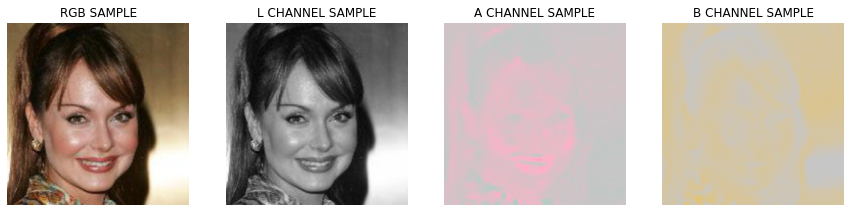

In [20]:
IMG_INDEX = 8

lab_im = next(iter(lab_loader))[0][IMG_INDEX]

plt.figure(figsize=(15, 14))

plt.subplot(141)
plt.imshow(np.transpose(c_im[0][IMG_INDEX], axes=(1, 2, 0)))
plt.axis('off')
plt.title('RGB SAMPLE')

plt.subplot(142)
plt.imshow(lab2rgb(lab_im, 0))
plt.axis('off')
plt.title('L CHANNEL SAMPLE')

plt.subplot(143)
plt.imshow(lab2rgb(lab_im, 1))
plt.axis('off')
plt.title('A CHANNEL SAMPLE')

plt.subplot(144)
plt.imshow(lab2rgb(lab_im, 2))
plt.axis('off')
plt.title('B CHANNEL SAMPLE')

In [21]:
l_im = next(iter(l_loader))

## Colorizing Images with Supervised Learning

In [55]:
class ColorNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=3, n_layers=(32, 64, 32, 8)):
        super(ColorNet, self).__init__()

        layers = []
        prev = in_channels

        for n in n_layers:
            layers.append(nn.Conv2d(in_channels=prev, out_channels=n, kernel_size=4, stride=2, padding=1)),
            layers.append(nn.BatchNorm2d(n)),
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=2.))
            prev = n

        layers.append(nn.Conv2d(in_channels=prev, out_channels=out_channels, kernel_size=3, stride=1, padding=1))

        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)

colorNet = ColorNet().to(device).double()
colorNet

ColorNet(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Upsample(scale_factor=2.0, mode=nearest)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode=nearest)
    (8): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Upsample(scale_factor=2.0, mode=nearest)
    (12): Conv2d(32, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Upsample(scale_factor=2.0, mode=nearest)
    (16): Conv2d(8, 3, kernel_size=(3, 3), st

In [56]:
count = 0
for param in colorNet.parameters():
    count += param.numel()

count

70771

In [59]:
torch.cuda.empty_cache()

criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(colorNet.parameters(), lr=lr)

epochs = 2
losses = []

start = time.time()

for i in range(epochs):
    i += 1

    for batch, (X, y) in enumerate(zip(l_loader, lab_loader)):
        batch += 1

        optimizer.zero_grad()

        X = X[0].to(device)
        y = y[0].to(device)

        y_pred = colorNet(X)
        loss = criterion(y_pred, y)

        if batch == 1 or batch % 500 == 0:
            losses.append(loss)
            print(f'Epoch: {i}/{epochs}, Batch: {batch}/{len(l_loader)} => Loss: {loss}')


        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to execute: {duration / 60:0.4f} minutes')

Epoch: 1/2, Batch: 1/2560 => Loss: 1208.7304695211399
Epoch: 1/2, Batch: 500/2560 => Loss: 86.86566614279123
Epoch: 1/2, Batch: 1000/2560 => Loss: 64.98375366119735
Epoch: 1/2, Batch: 1500/2560 => Loss: 44.40228362594421
Epoch: 1/2, Batch: 2000/2560 => Loss: 128.36713397058213
Epoch: 1/2, Batch: 2500/2560 => Loss: 68.90651592777444
Epoch: 2/2, Batch: 1/2560 => Loss: 64.25407518656414
Epoch: 2/2, Batch: 500/2560 => Loss: 73.04602547748901
Epoch: 2/2, Batch: 1000/2560 => Loss: 52.05046824879233
Epoch: 2/2, Batch: 1500/2560 => Loss: 39.810703202725726
Epoch: 2/2, Batch: 2000/2560 => Loss: 119.91561240222332
Epoch: 2/2, Batch: 2500/2560 => Loss: 63.87498483825293
Duration to execute: 45.3467 minutes


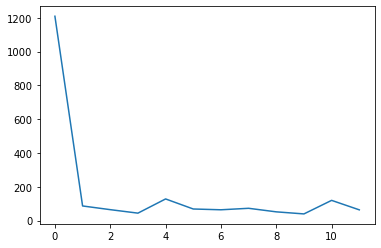

In [60]:
plt.plot(losses)

In [63]:
img_size = (image_size, image_size)

@torch.no_grad()
def view(image):

    colorNet.eval()

    image = colorNet(image.to(device))
    print(image.shape)

    image = lab2rgb(image.cpu().numpy().reshape(-1, *img_size))

    return image

torch.Size([1, 3, 256, 256])


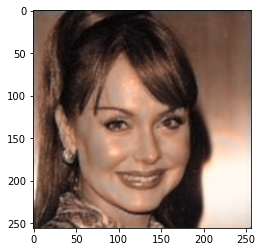

In [66]:
image = l_im[0][8]
image = view(image.view(-1, 1, *img_size).double())

plt.imshow(image)